In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns


plt.style.use("../figure.mplstyle")

In [17]:
# Load the CSV file
df = pd.read_csv("data/exp27/summary_final.csv")
# drop "Unnamed: 0" column
df = df.drop(columns=["Unnamed: 0"])

# load CSVs for runs
run_dfs = {}
for run in df["name"]:
    run_dfs[run] = pd.read_csv(f"data/exp27/{run}.csv")

print(len(run_dfs))

189


In [18]:
# process/filter runs

for run, run_df in run_dfs.items():
    # remove if max "trainer/global_step" < 25000
    if run_df["trainer/global_step"].max() < 25000:
        run_dfs[run] = None

run_dfs = {k: v for k, v in run_dfs.items() if v is not None}

print(len(run_dfs))

189


In [19]:
# Function to find the row closest to step 32000
def get_closest_row(df_run, target_step=32000):
    # Find the index of the row where "trainer/global_step" is closest to 32000
    closest_idx = (df_run["trainer/global_step"] - target_step).abs().idxmin()
    return df_run.loc[closest_idx]


# Replace the corresponding rows in the summary dataframe with the closest values
for run in df["name"]:
    if run not in run_dfs:
        # also remove from summary
        df = df[df["name"] != run]
        continue
    closest_row = get_closest_row(run_dfs[run])
    # Update each column in the summary dataframe with the closest values
    for col in closest_row.index:
        if col in df.columns:
            df.loc[df["name"] == run, col] = closest_row[col]

In [20]:
# write final_df to CSV
df.to_csv("data/exp27/summary_final.csv")

In [21]:
def human_readable(n: int) -> str:
    if n < 1e3:
        return str(n)
    if n < 1e6:
        return f"{round(n//1e3)}K"
    if n < 1e9:
        return f"{round(n//1e6)}M"
    return f"{round(n//1e9)}B"

## val loss vs embd dim

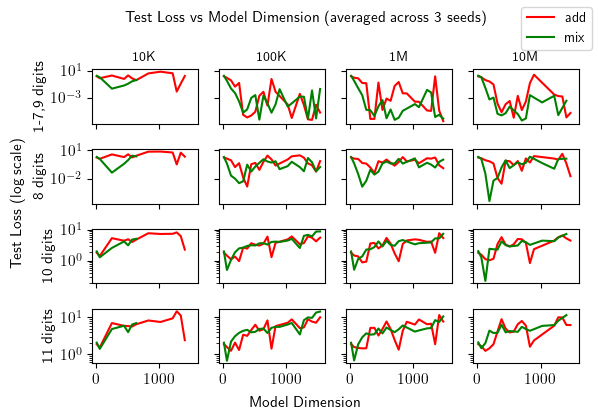

In [22]:
# List of relevant val_loss datasets
datasets = ["add_in_dist", "add_ood_8digit", "add_ood_10digit", "add_ood_11digit"]
train_sizes = [
    10000,
    100000,
    1000000,
    10000000,
]

# Prepare subplots with shared y axes only within rows and shared x axes for all
fig, axes = plt.subplots(
    len(datasets), len(train_sizes), sharex=True, sharey="row", figsize=(5.8, 4.0)
)
fig.suptitle("Test Loss vs Model Dimension (averaged across 3 seeds)")

# Define line colors for different tasks
task_colors = {"add": "red", "mix": "green"}

# Loop over datasets (rows) and train sizes (columns) to create subplots
for i, dataset in enumerate(datasets):
    for j, train_size in enumerate(train_sizes):
        for task_type, color in task_colors.items():
            # Filter data for the dataset, task, and train size
            subset = df[(df["task"] == task_type) & (df["train_size"] == train_size)]

            if subset.empty:
                continue  # Skip if no data is available for the combination

            grouped = (
                subset.groupby(["n_embd", "task", "train_size"])[f"val_loss/{dataset}"]
                .agg(["mean", "std"])
                .reset_index()
            )
            grouped = grouped.sort_values("n_embd")

            # Plot mean val_loss with a shaded area for the standard deviation
            axes[i, j].plot(
                grouped["n_embd"],
                grouped["mean"],
                label=f"{task_type}",
                color=color,
            )
            # axes[i, j].fill_between(
            #     grouped["n_embd"],
            #     grouped["mean"] - grouped["std"],
            #     grouped["mean"] + grouped["std"],
            #     color=color,
            #     alpha=0.3,
            # )

            # Set logarithmic scale for y-axis
            axes[i, j].set_yscale("log")

            # Set title for each column in the first row only (train sizes)
            if i == 0:
                axes[i, j].set_title(f"{human_readable(train_size)}", fontsize=10)

# Set shared x axis label in the middle
fig.text(0.5, -0.01, "Model Dimension", ha="center", fontsize=11)

# Set dataset labels only for the left side of the first column subplots
dataset_map = {
    "add_in_dist": "1-7,9 digits",
    "add_ood_8digit": "8 digits",
    "add_ood_10digit": "10 digits",
    "add_ood_11digit": "11 digits",
}
for i, dataset in enumerate(datasets):
    axes[i, 0].set_ylabel(dataset_map[dataset], fontsize=11, rotation=90)

# Add a single y-axis label for the whole figure
fig.text(
    -0.01, 0.5, "Test Loss (log scale)", va="center", rotation="vertical", fontsize=11
)

# Create a single legend outside the plot
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=10)

plt.tight_layout()  # Adjust layout to fit the legend and labels
plt.savefig("../latex/fig/exp_27_test_loss_vs_n_embd.png", dpi=300, bbox_inches="tight")
plt.show()

## subtask overfitting

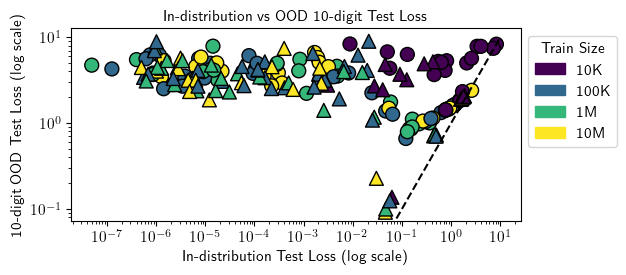

In [35]:
# Define a dictionary to map tasks to different markers
task_markers = {"add": "o", "mix": "^"}

# Get the unique train sizes and create a color map
unique_train_sizes = sorted(df["train_size"].unique())
cmap = plt.cm.viridis  # Sequential colormap
colors = cmap(
    np.linspace(0, 1, len(unique_train_sizes))
)  # Discrete colors from the colormap

# Create a dictionary to map each train_size to a specific color
train_size_color_map = {size: color for size, color in zip(unique_train_sizes, colors)}

fig, ax = plt.subplots(1, 1, figsize=(5.8, 2.5))

# Scatter plot for each task with color based on train_size
for task in task_markers.keys():
    subset = df[df["task"] == task]
    ax.scatter(
        subset["val_loss/add_in_dist"],
        subset["val_loss/add_ood_10digit"],
        c=subset["train_size"].map(train_size_color_map),  # Map train_size to colors
        label=task,  # Label for legend
        marker=task_markers[task],  # Marker based on task
        edgecolor="black",  # Add black edge to make markers more visible
        s=100,  # Increase marker size for better visibility
    )

# Plot diagonal line
x = np.linspace(0, 10, 10)
ax.plot(x, x, color="black", linestyle="--")

# Log-log plot
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("In-distribution Test Loss (log scale)")
ax.set_ylabel("10-digit OOD Test Loss (log scale)")

# Create a custom color legend for the train sizes
import matplotlib.patches as mpatches

handles = [
    mpatches.Patch(color=train_size_color_map[size], label=f"{human_readable(size)}")
    for size in unique_train_sizes
]
ax.legend(handles=handles, title="Train Size", loc="upper left", bbox_to_anchor=(1, 1))

ax.set_title("In-distribution vs OOD 10-digit Test Loss")

plt.savefig("../latex/fig/subtask_overfitting.png", dpi=300, bbox_inches="tight")

## Subtask difficulty

In [24]:
def plot_bar_with_error(ax, data, metric, subtask, categories, title=True):
    means = []
    stds = []
    valid_categories = []

    for category in categories:
        # Calculate mean and std for each category
        column_name = f"{metric}/{subtask}_{category}"
        if column_name in data.columns and data[column_name].notna().sum() > 0:
            mean_value = data[column_name].mean()
            std_value = data[column_name].std()
            means.append(mean_value)
            stds.append(std_value)
            valid_categories.append(category)

    # yerr = np.empty((2, len(means)))
    # stds = np.array(stds)
    # yerr[0, :] = np.clip(stds, 0, means)
    # yerr[1, :] = np.clip(stds, 0, 1 - np.array(means))

    # Plot bar with error bars (mean ± std) only if there is valid data
    ax.bar(valid_categories, means, yerr=stds, capsize=4)
    if title:
        ax.set_title(
            {
                "mad": "Modular\nAddition",
                "car": "Carry\nDetection",
                "ali": "Digit\nAlignment",
                "rev": "Reversing",
                "add": "Addition",
            }[subtask]
        )

/var/folders/w4/ynsxgc_j27s656r6t6f28pg00000gn/T/ipykernel_65038/2629264114.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(["ID", "8", "10", "11"], rotation=90)
/var/folders/w4/ynsxgc_j27s656r6t6f28pg00000gn/T/ipykernel_65038/2629264114.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(["ID", "8", "10", "11"], rotation=90)
/var/folders/w4/ynsxgc_j27s656r6t6f28pg00000gn/T/ipykernel_65038/2629264114.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(["ID", "8", "10", "11"], rotation=90)
/var/folders/w4/ynsxgc_j27s656r6t6f28pg00000gn/T/ipykernel_65038/2629264114.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e

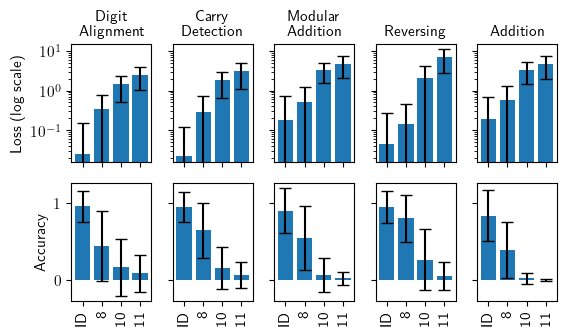

In [25]:
# Update subtasks to match the available columns in the dataset
subtasks = ["ali", "car", "mad", "rev", "add"]
categories = ["in_dist", "ood_8digit", "ood_10digit", "ood_11digit"]


# Create subplots with 2 rows (loss and accuracy) and 5 columns (subtasks)
fig, axes = plt.subplots(2, 5, figsize=(5.8, 3.5), sharey="row")

# Plot bar plots for each subtask and each category (loss)
for i, subtask in enumerate(subtasks):
    plot_bar_with_error(
        axes[0, i], df[df["task"] == "mix"], "val_loss", subtask, categories
    )
    if i == 0:
        axes[0, i].set_ylabel("Loss (log scale)")
    axes[0, i].set_yscale("log")
    axes[0, i].set_xticklabels([])

# Plot bar plots for each subtask and each category (accuracy)
for i, subtask in enumerate(subtasks):
    plot_bar_with_error(
        axes[1, i], df[df["task"] == "mix"], "val_acc", subtask, categories, title=False
    )
    if i == 0:
        axes[1, i].set_ylabel("Accuracy")
    axes[1, i].set_xticklabels(["ID", "8", "10", "11"], rotation=90)

# Adjust layout
plt.tight_layout()
plt.savefig("../latex/fig/subtask_difficulty.png", dpi=300, bbox_inches="tight")

## subtask order

In [26]:
mix_df = df[df["task"] == "mix"].copy()

In [27]:
mix_df

,name,task,n_embd,train_size,seed,trainer/global_step,val_loss/add_in_dist,val_loss/ali_in_dist,val_loss/car_in_dist,val_loss/mad_in_dist,...,val_acc/add_ood_10digit,val_acc/add_ood_11digit,val_acc/ali_ood_10digit,val_acc/ali_ood_11digit,val_acc/car_ood_10digit,val_acc/car_ood_11digit,val_acc/mad_ood_10digit,val_acc/mad_ood_11digit,val_acc/rev_ood_10digit,val_acc/rev_ood_11digit
1,tdec_768embd_mix_10000000_s1,mix,768,10000000,1,31999,0.000001,5.995229e-09,1.717648e-08,2.230348e-08,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,tdec_448embd_mix_10000000_s2,mix,448,10000000,2,31999,0.000006,8.349841e-09,2.123760e-08,5.691955e-08,...,0.00,0.00,0.0,0.00,0.06,0.00,0.00,0.00,0.27,0.00
6,tdec_1536embd_mix_100000_s1,mix,1536,100000,1,31021,0.021109,4.564957e-10,3.999832e-09,1.173784e-08,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.06,0.00
7,tdec_448embd_mix_1000000_s2,mix,448,1000000,2,31999,0.000003,2.066294e-09,5.821299e-09,1.653342e-07,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.26,0.00
9,tdec_1088embd_mix_1000000_s1,mix,1088,1000000,1,31999,0.000045,2.485147e-08,1.793622e-08,3.357544e-07,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,tdec_64embd_mix_1000000_s1,mix,64,1000000,1,31999,0.046622,8.593722e-06,9.405714e-04,3.229184e-04,...,0.38,0.06,1.0,0.21,0.98,0.61,0.95,0.43,0.97,0.00
169,tdec_448embd_mix_10000_s1,mix,448,10000,1,31999,0.090713,2.507670e-08,1.700806e-07,7.103448e-07,...,0.00,0.00,0.0,0.00,0.04,0.00,0.00,0.00,0.00,0.00
171,tdec_256embd_mix_100000_s1,mix,256,100000,1,31999,0.000221,1.551833e-07,7.078791e-07,2.850622e-06,...,0.00,0.00,0.0,0.00,0.10,0.00,0.00,0.00,0.00,0.00
172,tdec_64embd_mix_100000_s1,mix,64,100000,1,31999,0.056529,8.765651e-06,6.743842e-04,4.908003e-04,...,0.28,0.07,1.0,0.97,0.98,0.76,0.97,0.53,0.97,0.76


In [28]:
for subtask in subtasks:
    # Initialize the new columns in mix_df
    mix_df[f"{subtask}_grok_step"] = None

# add columns for when a task is learned
for run in mix_df["name"]:
    for subtask in subtasks:
        if run not in run_dfs:
            continue
        run_df = run_dfs[run]
        # sort by trainer/global_step
        run_df.sort_values("trainer/global_step")
        grok_step = (
            run_df.loc[
                run_df[f"val_acc/{subtask}_in_dist"] > 0.9, "trainer/global_step"
            ].iloc[0]
            if (run_df[f"val_acc/{subtask}_in_dist"] > 0.9).any()
            else None
        )
        # add grok_step to mix_df as new column for each subtask e.g. "add_grok_step" etc.
        mix_df.loc[mix_df["name"] == run, f"{subtask}_grok_step"] = grok_step

## Figure

In [29]:
a = np.array(
    [
        [0.070, 0.354, 0.000, 0.024],
        [0.215, 0.418, 0.000, 0.010],
        [0.161, 0.395, 0.000, 0.015],
        [0.186, 0.373, 0.000, 0.031],
    ]
)
a

array([[0.07 , 0.354, 0.   , 0.024],
       [0.215, 0.418, 0.   , 0.01 ],
       [0.161, 0.395, 0.   , 0.015],
       [0.186, 0.373, 0.   , 0.031]])

In [30]:
(a[:, 1] - a[:, 0]).mean(), (a[:, 3] - a[:, 2]).mean()

(0.22699999999999998, 0.02)